In [139]:
import torch
from torch.nn import LayerNorm as LayerNormTorch

In [140]:
import nntile

In [141]:
import numpy as np

In [142]:
nntile_config = nntile.starpu.Config(1,0,0,0)

In [143]:
nntile.starpu.init()

In [144]:
import nntile.utils.constructors as nntc
from nntile.layer.base_layer import BaseLayer
from nntile.tensor import (
    Tensor, TensorMoments, TensorTraits, add_fiber_inplace_async,
    add_inplace_async, add_slice_async, add_slice_inplace_async, clear_async,
    fill_async, hypot_scalar_inverse_async, norm_slice_async,
    prod_fiber3_async, prod_slice_async, sum_fiber_async, sum_slice_async,
    sumprod_fiber_async, sumprod_slice_async)

In [166]:
# ADAPTIVE LAYER NORMALIZATION NUMPY IMPLEMENTATION (BASIC)
def adaptive_layer_norm_numpy(x, gamma, beta, eps=1e-5, axis=-1):
    mean = np.mean(x, axis=axis, keepdims=True)
    var = np.var(x, axis=axis, keepdims=True)
    norm_x = (x - mean) / np.sqrt(var + eps)
    out = norm_x * gamma + beta
    return out

In [156]:
# EXAMPLE USAGE
np.random.seed(42)
x_input = np.random.randn(4, 8)
gamma = np.ones((8,))
beta = np.zeros((8,))

output_np = adaptive_layer_norm_numpy(x_input, gamma, beta)
print("Normalized output:\n", output_np)

Normalized output:
 [[-0.07900015 -1.00407124  0.14094753  1.41619229 -1.14376765 -1.14374373
   1.49804267  0.31540028]
 [ 0.16641908  1.4389799   0.17403494  0.17112769  1.06099973 -1.64906339
  -1.41221115  0.0497132 ]
 [-0.66614918  0.7578747  -0.55368579 -1.09480394  1.99338804  0.17840138
   0.4931323  -1.10815751]
 [-0.50911118  0.25246726 -1.2140982   0.56018223 -0.57449037 -0.21544276
  -0.57573148  2.2762245 ]]


In [196]:
# ADAPTIVE LAYER NORMALIZATION NUMPY IMPLEMENTATION (Basic - Object-Oriented Programming)

import numpy as np

class AdaptiveLayerNormNumpy:
    def __init__(self, embedding_dim, eps=1e-5):
        self.embedding_dim = embedding_dim
        self.eps = eps
        self.gamma = np.ones((1, embedding_dim), dtype=np.float32)  # Scale factor
        self.beta = np.zeros((1, embedding_dim), dtype=np.float32)  # Shift factor

    def forward(self, x):
        mean = np.mean(x, axis=-1, keepdims=True)
        var = np.var(x, axis=-1, keepdims=True)
        norm_x = (x - mean) / np.sqrt(var + self.eps)
        return norm_x * self.gamma + self.beta

# Example usage
if __name__ == "__main__":
    batch_size = 4
    embed_dim = 8
    np.random.seed(42)
    x = np.random.randn(batch_size, embed_dim).astype(np.float32)
    layer_norm = AdaptiveLayerNormNumpy(embed_dim)
    output = layer_norm.forward(x)

    print("Normalized output:")
    print(output)

Normalized output:
[[-0.07900018 -1.0040712   0.14094757  1.4161922  -1.1437677  -1.1437438
   1.4980427   0.31540024]
 [ 0.1664191   1.4389799   0.17403495  0.1711277   1.0609996  -1.6490633
  -1.4122112   0.04971324]
 [-0.66614914  0.75787467 -0.5536858  -1.0948039   1.993388    0.17840135
   0.4931323  -1.1081575 ]
 [-0.5091112   0.25246724 -1.2140982   0.5601822  -0.57449037 -0.21544276
  -0.5757315   2.2762246 ]]


In [197]:
# ADAPTIVE LAYER NORMALIZATION NNTile IMPLEMENTATION (BASIC1)
import torch
from torch.nn import LayerNorm as LayerNormTorch

import nntile.utils.constructors as nntc
from nntile.layer.base_layer import BaseLayer
from nntile.tensor import (
    Tensor, TensorMoments, TensorTraits, add_fiber_inplace_async,
    add_inplace_async, add_slice_async, add_slice_inplace_async, clear_async,
    fill_async, hypot_scalar_inverse_async, norm_slice_async,
    prod_fiber3_async, prod_slice_async, sum_fiber_async, sum_slice_async,
    sumprod_fiber_async, sumprod_slice_async)

In [198]:
def adaptive_layer_norm_nntile(x, tmp_y, y, gamma, beta, eps=1e-6, axis=-1):
    mean = np.mean(x, axis=axis, keepdims=True)
    mean1 = mean.reshape(mean.shape[:-1])
    mean_nnt = nntc.from_array(mean1)
    iv_std = 1.0/np.sqrt(np.var(x, axis=axis, keepdims=True)+eps)
    iv_std1 = iv_std.reshape(iv_std.shape[:-1])
    iv_std_nnt = nntc.from_array(iv_std1)
    x_nnt = nntc.from_array(x)
    tmp_y_nnt = nntc.from_array(tmp_y)
    y_nnt = nntc.from_array(y)
    gamma_nnt = nntc.from_array(gamma)
    beta_nnt = nntc.from_array(beta)
    add_slice_async(-1.0, mean_nnt, 1.0, x_nnt, tmp_y_nnt, len(x.shape)-1)
    prod_slice_async(iv_std_nnt, 1.0, tmp_y_nnt, len(x.shape)-1)
    prod_fiber3_async(gamma_nnt, 1.0, tmp_y_nnt, y_nnt, len(x.shape)-1)
    add_fiber_inplace_async(1.0, beta_nnt, 1.0, y_nnt, len(x.shape)-1, 0)
    res = nntc.to_numpy(y_nnt)
    return res  

In [199]:
# EXAMPLE USAGE
np.random.seed(42)
x = np.random.randn(4, 8)
print(len(x.shape))
mean = np.mean(x, axis=-1, keepdims=True)
print(mean.shape)
mean1 = mean.reshape(mean.shape[:-1])
print(mean1)
tmp_y = np.random.randn(4,8)
y = np.random.randn(4,8)
gamma = np.ones((8,))
beta = np.zeros((8,))

output_nnt = adaptive_layer_norm_nntile(x, tmp_y, y, gamma, beta, eps=1e-6, axis=-1)
print("Normalized output:\n", output_nnt)

2
(4, 1)
[ 0.55094068 -0.60182314 -0.39203238 -0.10631457]
Normalized output:
 [[-0.07900091 -1.00408083  0.14094888  1.41620581 -1.14377857 -1.14375465
   1.49805698  0.31540329]
 [ 0.16642026  1.43899014  0.17403618  0.17112891  1.06100728 -1.64907512
  -1.41222119  0.04971355]
 [-0.66615263  0.75787862 -0.55368866 -1.09480961  1.99339837  0.17840231
   0.49313486 -1.10816326]
 [-0.50911427  0.25246879 -1.21410558  0.56018564 -0.57449386 -0.21544407
  -0.57573498  2.27623833]]


In [200]:
# ADAPTIVE LAYER NORMALIZATION NNTile IMPLEMENTATION (BASIC1 - Object-Oriented Programming)
class AdaptiveLayerNormNNtile:
    def __init__(self, embedding_dim, eps=1e-5):
        self.embedding_dim = embedding_dim
        self.eps = eps
        self.gamma = np.ones((embed_dim,)).astype(np.float32)  # Scale factor
        self.beta = np.zeros((embed_dim,)).astype(np.float32)  # Shift factor

    def forward(self, x):
        mean = np.mean(x, axis=-1, keepdims=True)
        mean1 = mean.reshape(mean.shape[:-1])
        mean_nnt = nntc.from_array(mean1)
        iv_std = 1.0/np.sqrt(np.var(x, axis=-1, keepdims=True)+1e-5)
        iv_std1 = iv_std.reshape(iv_std.shape[:-1])
        iv_std_nnt = nntc.from_array(iv_std1)
        x_nnt = nntc.from_array(x)
        tmp_y_nnt = nntc.from_array(tmp_y)
        y_nnt = nntc.from_array(y)
        gamma_nnt = nntc.from_array(self.gamma)
        beta_nnt = nntc.from_array(self.beta)
        add_slice_async(-1.0, mean_nnt, 1.0, x_nnt, tmp_y_nnt, len(x.shape)-1)
        prod_slice_async(iv_std_nnt, 1.0, tmp_y_nnt, len(x.shape)-1)
        prod_fiber3_async(gamma_nnt, 1.0, tmp_y_nnt, y_nnt, len(x.shape)-1)
        add_fiber_inplace_async(1.0, beta_nnt, 1.0, y_nnt, len(x.shape)-1, 0)
        res = nntc.to_numpy(y_nnt)
        return res  

In [201]:
# EXAMPLE USAGE
batch_size = 4
embed_dim = 8
np.random.seed(42)
x = np.random.randn(batch_size, embed_dim).astype(np.float32)
tmp_y = np.random.randn(batch_size,embed_dim).astype(np.float32)
y = np.random.randn(batch_size,embed_dim).astype(np.float32)
# gamma = np.ones((embed_dim,)).astype(np.float32)
# beta = np.zeros((embed_dim,)).astype(np.float32)
layer_norm = AdaptiveLayerNormNNtile(embed_dim)
output_nnt = layer_norm.forward(x)
print("Normalized output:")
print(output)
# output_nnt = adaptive_layer_norm_nntile(x, tmp_y, y, gamma, beta, eps=1e-6, axis=-1)
# print("Normalized output:\n", output_nnt)

Normalized output:
[[-0.07900018 -1.0040712   0.14094757  1.4161922  -1.1437677  -1.1437438
   1.4980427   0.31540024]
 [ 0.1664191   1.4389799   0.17403495  0.1711277   1.0609996  -1.6490633
  -1.4122112   0.04971324]
 [-0.66614914  0.75787467 -0.5536858  -1.0948039   1.993388    0.17840135
   0.4931323  -1.1081575 ]
 [-0.5091112   0.25246724 -1.2140982   0.5601822  -0.57449037 -0.21544276
  -0.5757315   2.2762246 ]]


In [203]:
#ACCURACY METRICS:
#1) Mean Squared Error
import numpy as np
def mse(tensor1, tensor2):
    return np.mean((tensor1 - tensor2) ** 2)
print(mse(output, output_nnt))  # Lower is better

3.8233305e-15


In [205]:
#2) Mean Absolute Error
def mae(tensor1, tensor2):
    return np.mean(np.abs(tensor1 - tensor2))
print(mae(output, output_nnt))

3.213063e-08


In [207]:
#3) Cosine Similarity
from numpy.linalg import norm
def cosine_similarity(tensor1, tensor2):
    return np.dot(tensor1.flatten(), tensor2.flatten()) / (norm(tensor1) * norm(tensor2) + 1e-6)
print(cosine_similarity(output, output_nnt))  # Closer to 1 is better

1.0


In [208]:
#5) Pearson
def pearson_corr(tensor1, tensor2):
    return np.corrcoef(tensor1.flatten(), tensor2.flatten())[0, 1]
print(pearson_corr(output, output_nnt))

0.9999999999999984


In [209]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


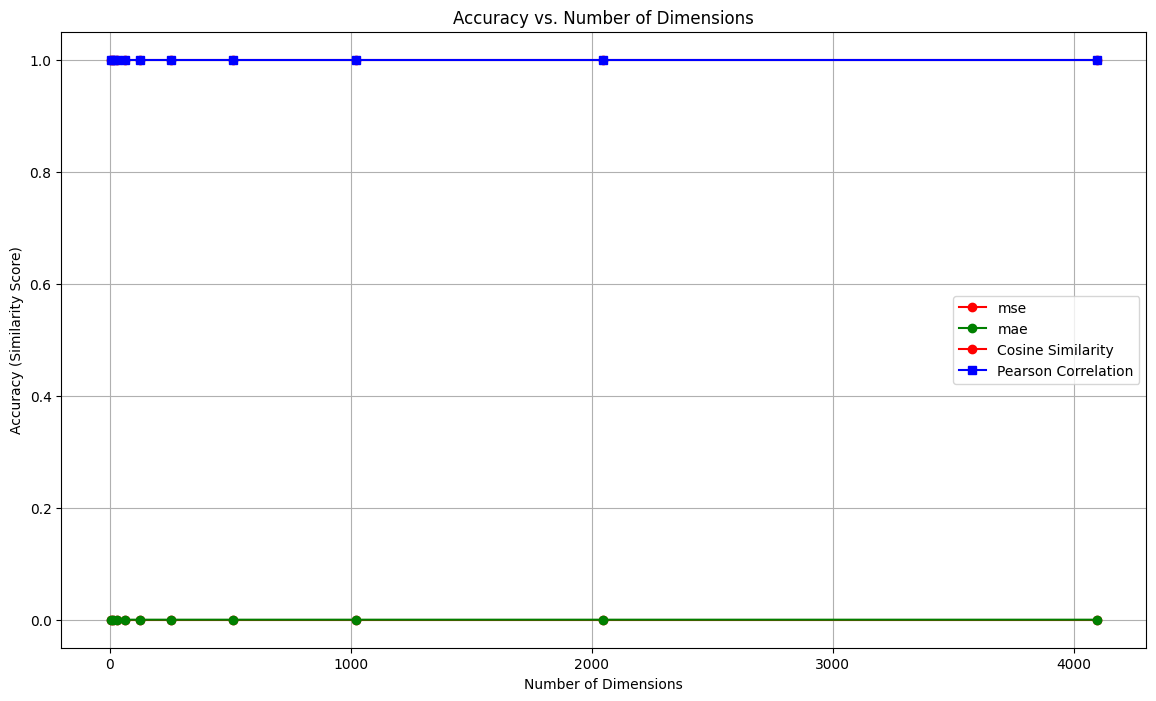

In [211]:
#Forward Graph-PLot-Numpy vs NNTile
import numpy as np
import torch
import matplotlib.pyplot as plt
#from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr
from torch.nn.functional import cosine_similarity

# Function to compute Mean Squared Error
def mse(tensor1, tensor2):
    return np.mean((tensor1 - tensor2) ** 2)

# Function to compute Mean Absolute Error
def mae(tensor1, tensor2):
    return np.mean(np.abs(tensor1 - tensor2))

# Function to compute Cosine Similarity
from numpy.linalg import norm
def cosine_similarity(tensor1, tensor2):
    return np.dot(tensor1.flatten(), tensor2.flatten()) / (norm(tensor1) * norm(tensor2) + 1e-6)

# Function to compute Pearson Correlation
def pearson_corr(tensor1, tensor2):
    return np.corrcoef(tensor1.flatten(), tensor2.flatten())[0, 1]

# Function to compute Structural Similarity Index (SSIM)
# def compute_ssim(tensor1, tensor2):
#     return ssim(tensor1, tensor2, data_range=tensor2.max() - tensor2.min())

# Increasing dimensions
dimensions = [4, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

# Store accuracy values
mse_values = []
mae_values = []
cosine_values = []
pearson_values = []
#ssim_values = []

# Generate tensors and compute metrics
for dim in dimensions:
    np.random.seed(42)
    x = np.random.randn(dim, dim)
    tmp_y = np.random.randn(dim,dim)
    y = np.random.randn(dim,dim)
    gamma = np.ones((dim,))
    beta = np.zeros((dim,))
    output_np = adaptive_layer_norm_numpy(x, gamma, beta)
    output_nnt = adaptive_layer_norm_nntile(x, tmp_y, y, gamma, beta, eps=1e-6, axis=-1)
    # tensor1 = np.random.randn(dim, dim).astype(np.float32)
    # tensor2 = tensor1 + np.random.randn(dim, dim) * 0.1  # Adding slight noise
    mse_values.append(mse(output_np, output_nnt))
    mae_values.append(mae(output_np, output_nnt))
    cosine_values.append(cosine_similarity(output_np, output_nnt))
    pearson_values.append(pearson_corr(output_np, output_nnt))
    #ssim_values.append(compute_ssim(tensor1, tensor2))

# Plot Accuracy vs. Number of Dimensions
plt.figure(figsize=(14, 8))

plt.plot(dimensions, mse_values, marker='o', linestyle='-', label="mse", color='r')
plt.plot(dimensions, mae_values, marker='o', linestyle='-', label="mae", color='g')
plt.plot(dimensions, cosine_values, marker='o', linestyle='-', label="Cosine Similarity", color='r')
plt.plot(dimensions, pearson_values, marker='s', linestyle='-', label="Pearson Correlation", color='b')
#plt.plot(dimensions, ssim_values, marker='d', linestyle='-', label="SSIM", color='r')

plt.xlabel("Number of Dimensions")
plt.ylabel("Accuracy (Similarity Score)")
plt.title("Accuracy vs. Number of Dimensions")
plt.legend()
plt.grid()
plt.show()

In [212]:
# Adaptive Layer Normalization Numpy (Main Implementation)
import numpy as np

def silu(x):
    return x * (1.0 / (1.0 + np.exp(-x)))

def layer_norm(x, axis=-1, eps=1e-6):
    mean = np.mean(x, axis=axis, keepdims=True)
    var = np.var(x, axis=axis, keepdims=True)
    return (x - mean) / np.sqrt(var + eps)

class AdaptiveLayerNormZeroNumpy:
    def __init__(self, embedding_dim, bias=True):
        self.embedding_dim = embedding_dim
        self.bias_flag = bias
        self.W = np.random.randn(6 * embedding_dim, embedding_dim).astype(np.float32)
        if bias:
            self.b = np.random.randn(6 * embedding_dim).astype(np.float32)
        else:
            self.b = None

    def linear(self, x):
        out = np.dot(x, self.W.T)
        if self.bias_flag and self.b is not None:
            out = out + self.b
        return out

    def forward(self, x, emb):
        activated_emb = silu(emb)
        lin_out = self.linear(activated_emb)  
        chunks = np.split(lin_out, 6, axis=1)
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = chunks
        norm_x = layer_norm(x, axis=-1, eps=1e-6)
        x_out = norm_x * (1 + scale_msa) + shift_msa
        
        return x_out, gate_msa, shift_mlp, scale_mlp, gate_mlp

In [213]:
import numpy as np

if __name__ == "__main__":
  
    batch_size = 4
    embed_dim = 8
    np.random.seed(42)
    x = np.random.randn(batch_size, embed_dim).astype(np.float32)
    emb = np.random.randn(batch_size, embed_dim).astype(np.float32)
    ada_ln_numpy = AdaptiveLayerNormZeroNumpy(embed_dim, bias=True)
    x_out, gate_msa, shift_mlp, scale_mlp, gate_mlp = ada_ln_numpy.forward(x, emb)
    
    print("Output after adaptive layer normalization (NumPy):")
    print(x_out)
    print("gate_msa:")
    print(gate_msa)
    print("shift_mlp:")
    print(shift_mlp)
    print("scale_mlp:")
    print(scale_mlp)
    print("gate_mlp:")
    print(gate_mlp)

Output after adaptive layer normalization (NumPy):
[[-0.97028106 -4.4154916   0.6177989   1.4213154  -5.2005672   0.9943297
  -1.9142547   0.96002084]
 [ 1.5100112  -2.829732    0.43811035 -0.25721028  2.9262955  -1.9289116
  -0.62733406 -1.2002949 ]
 [-0.91099644 -3.7880785   0.6780937   0.35873395  7.8668194  -0.5025041
  -1.0716336  -1.3217349 ]
 [-1.0746773  -0.71024644  1.1459168   1.9817605  -1.6744788   1.4462551
  -2.3191943   1.6922414 ]]
gate_msa:
[[-0.06117916 -0.06997404 -0.30707735  0.88067013 -0.5081278   0.64808494
  -0.18654944 -3.0348396 ]
 [-0.88068235  0.7265208   1.289567   -1.2174855  -0.19440359  0.48698002
  -0.8397361  -2.3659282 ]
 [-0.23199075  0.42254692 -0.03831857 -1.2650453  -0.7041243   0.50829417
  -1.101046   -3.984528  ]
 [ 0.7533198   0.61761516  0.5402827   0.9408478  -1.0901275   0.6611101
   1.211527   -2.3183763 ]]
shift_mlp:
[[-0.59400797  2.4008093   1.0521076   1.64451     0.31480193  0.40895754
   4.2330523   1.6819515 ]
 [-1.028963   -0.07451

In [214]:
# Adaptive Layer Normalization Pytorch (Main Implementation)
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdaptiveLayerNormZeroTorch(nn.Module):
    def __init__(self, embedding_dim, bias=True):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.bias_flag = bias
        self.W = nn.Parameter(torch.randn(6 * embedding_dim, embedding_dim))
        self.b = nn.Parameter(torch.randn(6 * embedding_dim)) if bias else None
        self.eps = 1e-6

    def linear(self, x):
        out = F.linear(x, self.W, self.b)
        return out

    def forward(self, x, emb):
        activated_emb = F.silu(emb)
        lin_out = self.linear(activated_emb)
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = torch.chunk(lin_out, 6, dim=-1)
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, unbiased=False, keepdim=True)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        x_out = norm_x * (1 + scale_msa) + shift_msa
        
        return x_out, gate_msa, shift_mlp, scale_mlp, gate_mlp

In [215]:
# Example usage

if __name__ == "__main__":
    batch_size = 4
    embed_dim = 8
    
import torch
import random
import numpy as np

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

torch.random.seed()
x = torch.randn(batch_size, embed_dim)
emb = torch.randn(batch_size, embed_dim)
ada_ln_torch = AdaptiveLayerNormZeroTorch(embed_dim, bias=True)
x_out, gate_msa, shift_mlp, scale_mlp, gate_mlp = ada_ln_torch(x, emb)

print("Output after adaptive layer normalization (Torch):")
print(x_out)
print("gate_msa:")
print(gate_msa)
print("shift_mlp:")
print(shift_mlp)
print("scale_mlp:")
print(scale_mlp)
print("gate_mlp:")
print(gate_mlp)

Output after adaptive layer normalization (Torch):
tensor([[-1.0641, -3.5341,  3.4647, -0.2473, -6.8416,  4.0018,  0.3171, -0.7442],
        [ 3.6900,  5.9600,  3.2149, -0.1561,  2.0138,  6.3230, -0.1986,  1.6786],
        [ 2.2520, -1.8810, -1.4966, -0.5699, -0.2448,  1.5351, -0.0150,  4.2630],
        [ 0.9482, -2.1591,  0.9904,  3.9860,  6.2351,  0.8681,  3.5936,  0.2698]],
       grad_fn=<AddBackward0>)
gate_msa:
tensor([[-4.0983, -0.9261,  1.3980,  1.5764, -1.7721, -0.9242, -2.3236, -1.3845],
        [-4.7207,  0.5637,  0.0986,  3.1418, -1.9622, -2.1526, -0.4547, -1.8852],
        [ 0.4681, -1.5951, -0.6640, -1.3623, -2.8250, -0.5248, -0.0517, -1.4985],
        [-3.5972, -3.0065,  2.9711, -0.9779, -3.6447, -2.1877, -4.1187, -1.2627]],
       grad_fn=<SplitBackward0>)
shift_mlp:
tensor([[ 1.4530,  0.9016,  1.9484, -1.7241,  2.3396, -1.3340, -1.6018,  1.7285],
        [ 1.5122,  3.1788,  0.2101, -1.9482,  2.5912,  0.4057, -2.8164,  0.1947],
        [-0.0411, -2.7350,  3.5817, -1.040

In [240]:
# Adaptive Layer Normalization NNtile (Main Implementation)
import numpy as np
from nntile.functions import (silu_forward_async, add_slice_async, prod_slice_async, transpose_async, prod_async, add_inplace_async, add_async)


def layer_norm(x, axis=-1, eps=1e-6):
    mean = np.mean(x, axis=axis, keepdims=True)
    mean1 = mean.reshape(mean.shape[:-1])
    mean_nnt = nntc.from_array(mean1)
    tmp_y = nntc.from_array(np.random.randn(batch_size, embed_dim))
    iv_std = 1.0/np.sqrt(np.var(x, axis=-1, keepdims=True)+1e-5)
    iv_std1 = iv_std.reshape(iv_std.shape[:-1])
    iv_std_nnt = nntc.from_array(iv_std1)
    x_nnt = nntc.from_array(x)
    tmp_y_nnt = nntc.from_array(tmp_y)
    add_slice_async(-1.0, mean_nnt, 1.0, x_nnt, tmp_y_nnt, len(x.shape)-1)
    prod_slice_async(iv_std_nnt, 1.0, tmp_y_nnt, len(x.shape)-1)
    return tmp_y_nnt

class AdaptiveLayerNormZeroNNtile:
    def __init__(self, embedding_dim, bias=True):
        np.random.seed(42)
        self.embedding_dim = embedding_dim
        self.bias_flag = bias
        self.W = nntc.from_array(np.random.randn(embedding_dim, embedding_dim).astype(np.float32))
        self.W_T = nntc.from_array(np.transpose(np.random.randn(embedding_dim, embedding_dim)).astype(np.float32))
        if bias:
            self.b = nntc.from_array(np.random.randn(embedding_dim).astype(np.float32))
        else:
            self.b = None

    def linear(self, x):
        #x_nnt = nntc.from_array(x)
        out_nnt = nntc.from_array(np.random.randn(batch_size,embed_dim).astype(np.float32))
        #x_nnt1 = nntc.from_array(np.random.randn(batch_size, 6*embed_dim).astype(np.float32))
        #transpose_async(1.0, self.W, self.W_T, self.W.ndim)
        #prod_slice_async(self.W, 1.0, x, len(x.shape)-1)
        prod_async(x, self.W_T, out_nnt)
        if self.bias_flag and self.b is not None:
            add_inplace_async(1.0, self.b, 1.0, out_nnt)
        return out_nnt

    def forward(self, x, emb):
        x_nnt = nntc.from_array(x)
        emb_nnt = nntc.from_array(emb)
        emb_nnt_silu = nntc.from_array(emb)
        #emb_nnt_silu = nntc.from_array(np.random.randn(batch_size, embed_dim).astype(np.float32))
        silu_forward_async(emb_nnt, emb_nnt_silu)
        shift_msa_nnt = self.linear(emb_nnt_silu)
        scale_msa_nnt = self.linear(emb_nnt_silu)
        gate_msa_np = nntc.to_numpy(self.linear(emb_nnt_silu))
        shift_mlp_np = nntc.to_numpy(self.linear(emb_nnt_silu))
        scale_mlp_np = nntc.to_numpy(self.linear(emb_nnt_silu))
        gate_mlp_np = nntc.to_numpy(self.linear(emb_nnt_silu))
        norm_x = layer_norm(x, axis=-1, eps=1e-6)
        scale_msa_tmp = nntc.from_array(np.random.randn(batch_size, embedding_dim).astype(np.float32))
        prod_async(norm_x,scale_msa, scale_msa_tmp)
        add_inplace_async(1.0,scale_msa_tmp, 1.0,norm_x)
        x_out = nntc.from_array(np.random.randn(batch_size, embedding_dim).astype(np.float32))
        add_async(1.0,shift_msa, 1.0,norm_x,x_out)
        x_out_np = nntc.to_numpy(x_out)       
        return x_out_np, gate_msa_np, shift_mlp_np, scale_mlp_np, gate_mlp_np

In [241]:
import numpy as np

if __name__ == "__main__":
  
    batch_size = 4
    embed_dim = 8
    np.random.seed(42)
    x = np.random.randn(batch_size, embed_dim).astype(np.float32)
    emb = np.random.randn(batch_size, embed_dim).astype(np.float32)
    ada_ln_nntile = AdaptiveLayerNormZeroNNtile(embed_dim, bias=True)
    x_out_np, gate_msa, shift_mlp, scale_mlp, gate_mlp = ada_ln_nntile.forward(x, emb)
    
    print("Output after adaptive layer normalization (NNtile):")
    print(x_out)
    print("gate_msa:")
    print(gate_msa)
    print("shift_mlp:")
    print(shift_mlp)
    print("scale_mlp:")
    print(scale_mlp)
    print("gate_mlp:")
    print(gate_mlp)

RuntimeError: src1.shape != src2.shape